Not working yet

OpenAI environment : https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

SFFF       (S: starting point, safe)  
FHFH       (F: frozen surface, safe)  
FFFH       (H: hole, fall to your doom)  
HFFG       (G: goal, where the frisbee is located)

In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch
import time

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

import gym

C:\Users\Portable\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
env = gym.make('FrozenLake-v0')
nb_neurons = 40
#emperature = 2000
learning_rate = 0.01
gamma = 0.8
e = 0.15

In [3]:
class brain(nn.Module):
    
    def __init__(self):
        super(brain,self).__init__()
        self.fc1 = nn.Linear(16,nb_neurons)
        self.fc2 = nn.Linear(nb_neurons,env.action_space.n)
    
    def forward(self,state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

In [4]:
class DQN():
    def __init__(self,gamma):
        self.model=brain()
        self.gamma = gamma
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        
    def select_action(self,state):
        #probs=F.softmax(self.model(torch.Tensor(state).detach())*temperature)
        #action = probs.multinomial(4)
        action = np.argmax(self.model(torch.Tensor(state).detach()).data)
        if np.random.rand(1)<e:
            action = env.action_space.sample()
        else:
            action = np.argmax(self.model(torch.Tensor(state).detach()).data)
        return action
    
    def learn(self, current_state, next_state,reward,action):
        #with torch.no_grad():
        output = self.model(current_state)
        #print(current_state.grad)
        #print(output)
        next_output = self.model(next_state).detach()
        #print(next_output)
        #print(next_output.detach().max()[0])
        target = (reward + self.gamma*(next_output.detach().max()[0])).detach()
        #print(next_output.requires_grad)
        td_loss = F.smooth_l1_loss(output[action], target)
        #td_loss = (output[action] - target)**2
        #print(td_loss)
        #print(td_loss)
        self.optimizer.zero_grad()
        td_loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        

In [5]:
number_episodes = 3000
ai = DQN(gamma)
all_reward = []

for episode in range(number_episodes):
    
    current_state=torch.randn(1,16,requires_grad=True)
    current_state = torch.Tensor(to_categorical(env.reset(), num_classes = 16))
    #print(current_state)
    #current_state = to_categorical(current_state, num_classes = 16)
    #print(ai.model(torch.Tensor(current_state)))
    cumulative_reward = 0
    for t in range(100):
        action = ai.select_action(current_state)
        next_state, reward, done, _ = env.step(np.int64(action))      
        next_state = to_categorical(next_state, num_classes = 16)
        #if current_state[14]==1:
        #    print(reward)
        #    print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
        ai.learn(torch.Tensor(current_state),torch.Tensor(next_state),reward,action)
        #if current_state[14]==1:
        #    print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
        cumulative_reward+=reward 
        #env.render()
        if done:
            break
        current_state = next_state
    #print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
    all_reward.append(cumulative_reward)

C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [6]:
learning = []
y = []
batch_size = 200
for i in range(0,len(all_reward),batch_size):
    learning.append(sum(all_reward[i:i+batch_size])/batch_size)
    y.append(i)

Text(0.5,1,'Evolution of the reward')

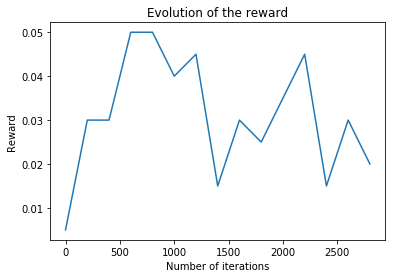

In [7]:
plt.plot(y,learning)
plt.ylabel('Reward')
plt.xlabel('Number of iterations')
plt.title('Evolution of the reward')

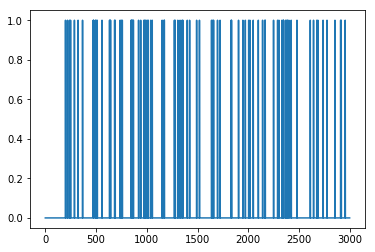

In [8]:
plt.plot(all_reward)